In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm
from captum.attr import GuidedGradCam
from captum.attr import visualization as viz
from numpy import ndarray
from enum import Enum
from typing import Any, Iterable, List, Optional, Tuple, Union
import warnings
import matplotlib.pyplot as plt
import cv2
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
# from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg

/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from myModelsAll import MyEfficientNet_3channel, MyEfficientNet_4channel
from config import MyTansforms,MyDataset
from data_loader import MyDataLoading_color,MyDataLoading_four_channel

In [3]:
class VisualizeSign(Enum):
    positive = 1
    absolute_value = 2
    negative = 3
    all = 4

def _cumulative_sum_threshold(values: ndarray, percentile: Union[int, float]):
    # given values should be non-negative
    assert percentile >= 0 and percentile <= 100, (
        "Percentile for thresholding must be " "between 0 and 100 inclusive."
    )
    sorted_vals = np.sort(values.flatten())
    cum_sums = np.cumsum(sorted_vals)
    threshold_id = np.where(cum_sums >= cum_sums[-1] * 0.01 * percentile)[0][0]
    return sorted_vals[threshold_id]

def _normalize_attr(
    attr: ndarray,
    sign: str,
    outlier_perc: Union[int, float] = 2,
    reduction_axis: Optional[int] = None,
):
    attr_combined = attr
    if reduction_axis is not None:
        attr_combined = np.sum(attr, axis=reduction_axis)

    # Choose appropriate signed values and rescale, removing given outlier percentage.
    if VisualizeSign[sign] == VisualizeSign.all:
        threshold = _cumulative_sum_threshold(np.abs(attr_combined), 100 - outlier_perc)
    elif VisualizeSign[sign] == VisualizeSign.positive:
        attr_combined = (attr_combined > 0) * attr_combined
        threshold = _cumulative_sum_threshold(attr_combined, 100 - outlier_perc)
    elif VisualizeSign[sign] == VisualizeSign.negative:
        attr_combined = (attr_combined < 0) * attr_combined
        threshold = -1 * _cumulative_sum_threshold(
            np.abs(attr_combined), 100 - outlier_perc
        )
    elif VisualizeSign[sign] == VisualizeSign.absolute_value:
        attr_combined = np.abs(attr_combined)
        threshold = _cumulative_sum_threshold(attr_combined, 100 - outlier_perc)
    else:
        raise AssertionError("Visualize Sign type is not valid.")
    return _normalize_scale(attr_combined, threshold)

def _normalize_scale(attr: ndarray, scale_factor: float):
    assert scale_factor != 0, "Cannot normalize by scale factor = 0"
    if abs(scale_factor) < 1e-5:
        warnings.warn(
            "Attempting to normalize by value approximately 0, visualized results"
            "may be misleading. This likely means that attribution values are all"
            "close to 0."
        )
    attr_norm = attr / scale_factor
    return np.clip(attr_norm, -1, 1)

/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.9, which is newer than your current Lightning version: v1.9.5
  rank_zero_warn(
/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ENTERED 3CHANNEL


  0%|          | 0/1232 [00:00<?, ?it/s]/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


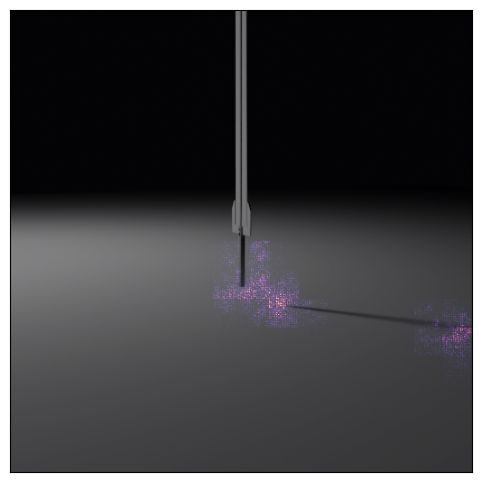

/tmp/ipykernel_62064/871380153.py:18: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  myArr = np.frombuffer(myCanvas.tostring_rgb(), dtype=np.uint8).reshape(h,w,3)
  0%|          | 1/1232 [00:00<11:19,  1.81it/s]/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


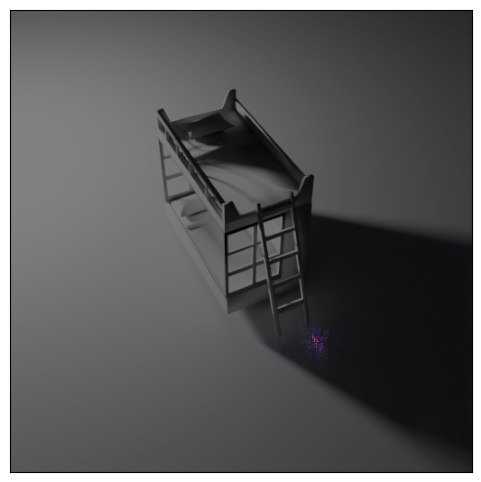

/tmp/ipykernel_62064/871380153.py:18: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  myArr = np.frombuffer(myCanvas.tostring_rgb(), dtype=np.uint8).reshape(h,w,3)
  0%|          | 2/1232 [00:00<07:10,  2.86it/s]/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


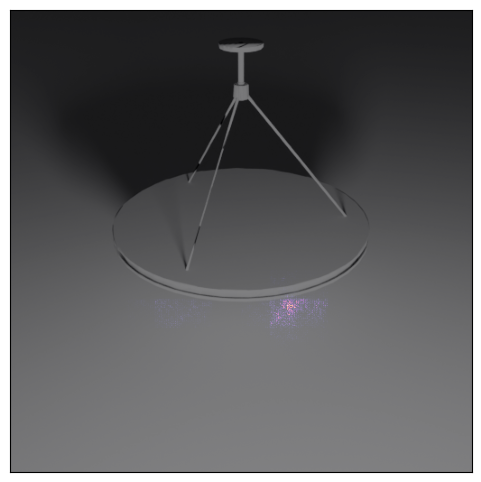

/tmp/ipykernel_62064/871380153.py:18: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  myArr = np.frombuffer(myCanvas.tostring_rgb(), dtype=np.uint8).reshape(h,w,3)
  0%|          | 3/1232 [00:00<05:46,  3.54it/s]/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


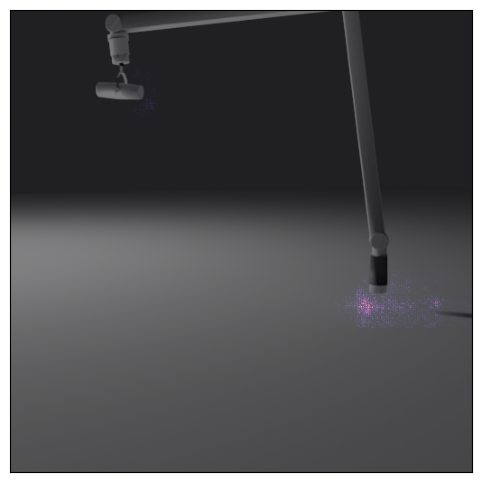

/tmp/ipykernel_62064/871380153.py:18: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  myArr = np.frombuffer(myCanvas.tostring_rgb(), dtype=np.uint8).reshape(h,w,3)
  0%|          | 4/1232 [00:01<05:05,  4.03it/s]/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


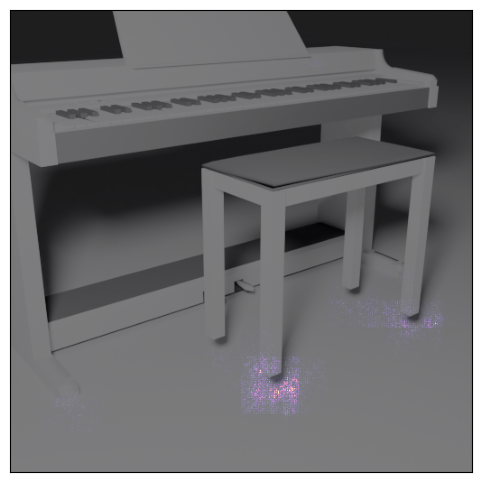

/tmp/ipykernel_62064/871380153.py:18: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  myArr = np.frombuffer(myCanvas.tostring_rgb(), dtype=np.uint8).reshape(h,w,3)
  0%|          | 5/1232 [00:01<04:48,  4.26it/s]/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


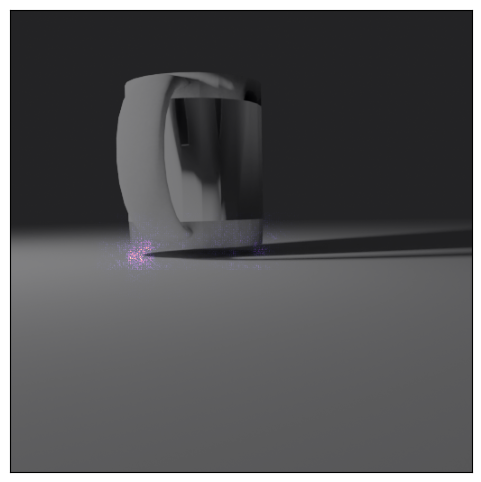

/tmp/ipykernel_62064/871380153.py:18: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  myArr = np.frombuffer(myCanvas.tostring_rgb(), dtype=np.uint8).reshape(h,w,3)
  0%|          | 6/1232 [00:01<04:35,  4.45it/s]/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


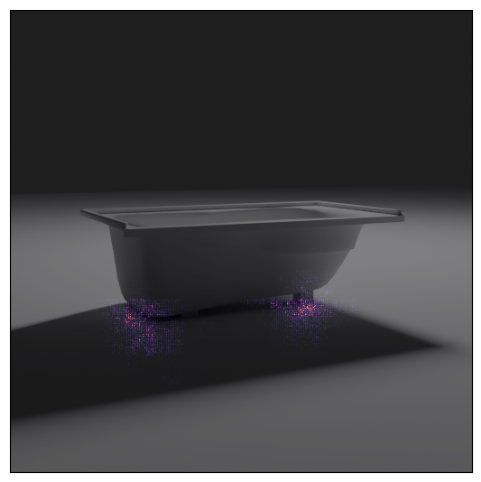

/tmp/ipykernel_62064/871380153.py:18: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  myArr = np.frombuffer(myCanvas.tostring_rgb(), dtype=np.uint8).reshape(h,w,3)
  1%|          | 7/1232 [00:01<04:24,  4.64it/s]/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


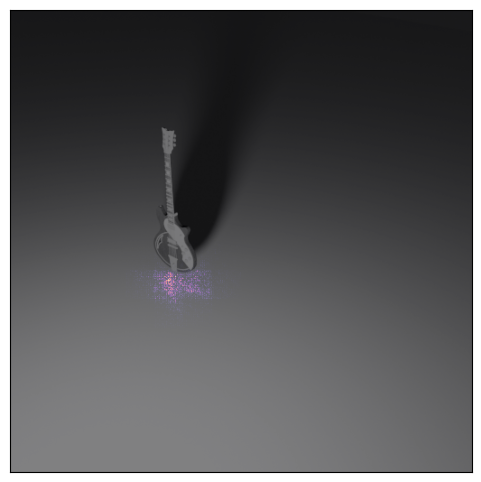

/tmp/ipykernel_62064/871380153.py:18: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  myArr = np.frombuffer(myCanvas.tostring_rgb(), dtype=np.uint8).reshape(h,w,3)
  1%|          | 8/1232 [00:01<04:17,  4.75it/s]/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


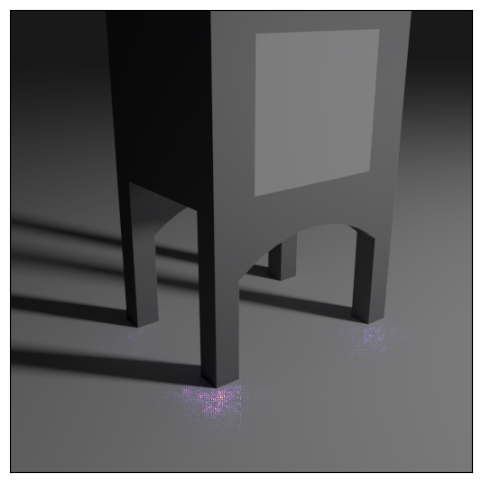

/tmp/ipykernel_62064/871380153.py:18: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  myArr = np.frombuffer(myCanvas.tostring_rgb(), dtype=np.uint8).reshape(h,w,3)
  1%|          | 9/1232 [00:02<04:22,  4.66it/s]/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


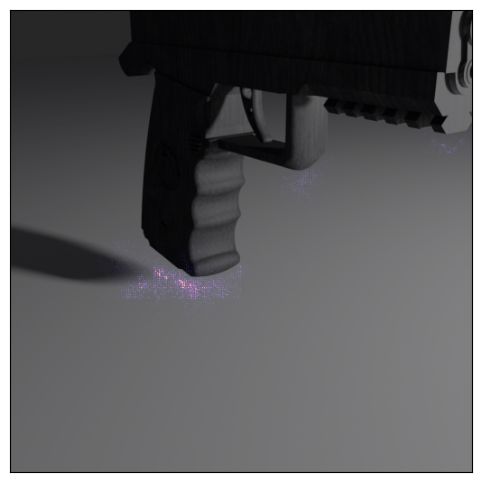

/tmp/ipykernel_62064/871380153.py:18: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  myArr = np.frombuffer(myCanvas.tostring_rgb(), dtype=np.uint8).reshape(h,w,3)
  1%|          | 10/1232 [00:02<04:23,  4.63it/s]/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


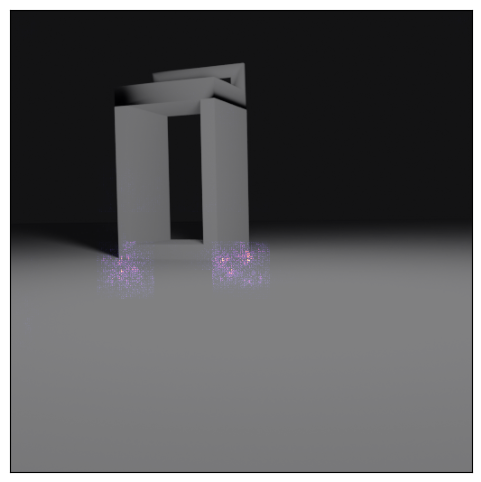

/tmp/ipykernel_62064/871380153.py:18: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  myArr = np.frombuffer(myCanvas.tostring_rgb(), dtype=np.uint8).reshape(h,w,3)
  1%|          | 10/1232 [00:02<05:23,  3.78it/s]


10
10
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.88      1.00      0.93         7

    accuracy                           0.90        10
   macro avg       0.94      0.83      0.87        10
weighted avg       0.91      0.90      0.89        10

[[2 1]
 [0 7]]


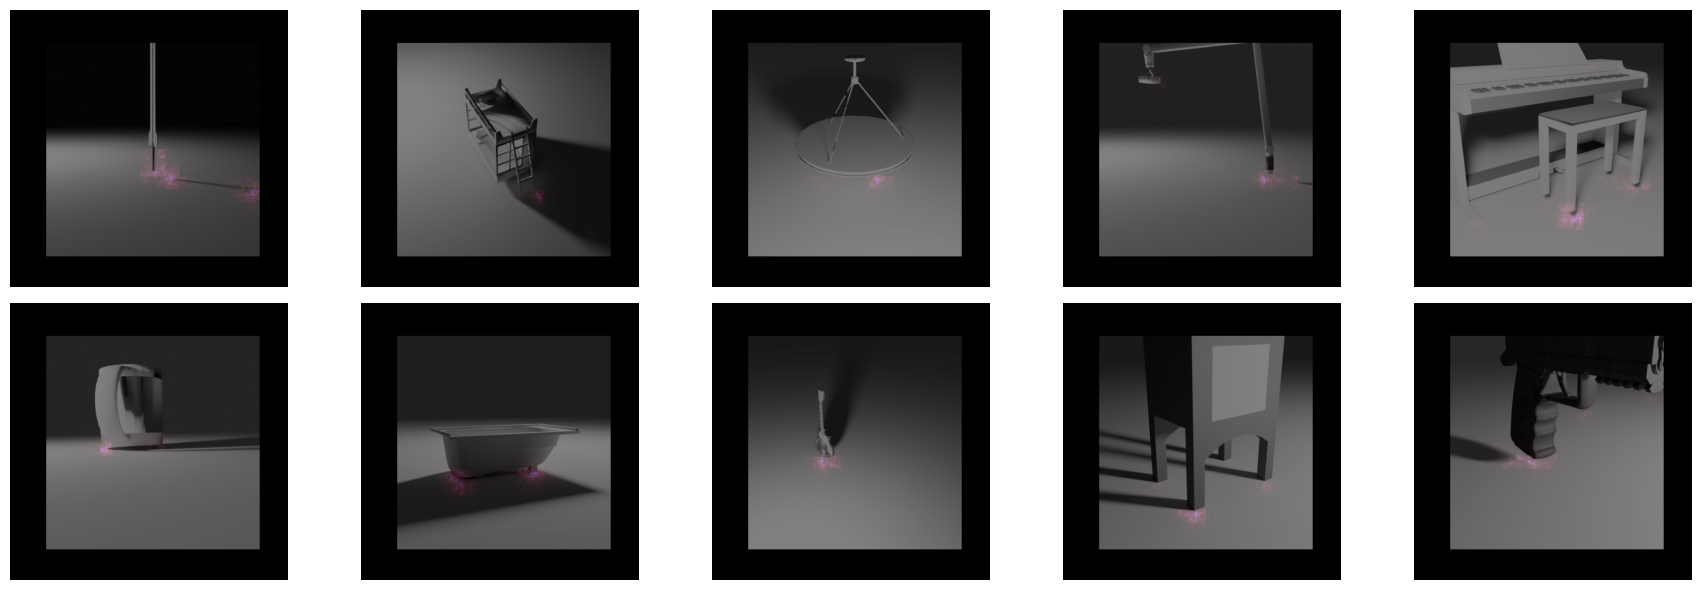

In [4]:


def pltDimensions(X, ori=False):
    # print(X.shape)
    X = X.squeeze(0)
    X = torch.permute(X, (1,2,0))
    X = X.cpu().numpy()
    if ori==True:
        if X.shape[2] != 3:
            X = X[:, :, :3]
        X = np.array(X, dtype=int)
    # print(X.shape)
    return X

def figArr(fig, draw=True):
    fig.set_facecolor("black")
    myCanvas = fig.canvas
    myCanvas.draw()
    w,h = myCanvas.get_width_height()
    myArr = np.frombuffer(myCanvas.tostring_rgb(), dtype=np.uint8).reshape(h,w,3)
    # myArr = myArr[:, :, :-1]
    myImg = cv2.cvtColor(myArr, cv2.COLOR_RGB2BGR)
    return myImg

def main(myModelPath, model_architecture = MyEfficientNet_3channel):
    model = model_architecture.load_from_checkpoint(myModelPath)
    model.eval()
    model.cuda()
    
    #____________________________
    # base_path = "/panfs/jay/groups/27/kersten/gejji003/Shadows/data/images_rendered_try2/" # loaction of train test
    base_path = "/home/atharva/Downloads/code/"
    file_path_test = base_path +"testData.csv"
    file_path_train = base_path +"trainData.csv"
    file_path_val = base_path +"valData.csv"

    train_df = pd.read_csv(file_path_train)
    val_df = pd.read_csv(file_path_val)
    test_df = pd.read_csv(file_path_test)

    theDataLoader = "three_channel" #MyDataLoading_color
    color_channel = "colors"
    shadow_channel = "cast_shadow"
    mount_point = "/home/atharva/Abha/Shadows/images_rendered_try2/"

    #____________________________

    dataLoader = MyDataset(train_df, val_df, test_df, color_channel, shadow_channel, theDataLoader, mount_point, batch_size=1, num_workers=4)
    test_loader = dataLoader.test_dataloader()
    last_conv_layer = model.model.features[8][0]
    myGradcam = GuidedGradCam(model, last_conv_layer)
    y_all = []
    pred_all = []

    with torch.no_grad():
        pbar = tqdm(enumerate(test_loader), total=len(test_loader))
        individual_figures = []

        for idx, X in pbar:
            X, y = X
            X = X.cuda().contiguous()

            myPred = model(X).squeeze().cuda()
            myPred = myPred.cpu().detach().numpy()
        
            myPred = np.argmax(myPred)
            myPred = int(myPred)
          
            myAttr = myGradcam.attribute(X, myPred)
           
            myVis = _normalize_attr(myAttr.cpu(), sign = "absolute_value")
            myVis = pltDimensions(myVis)
            myOri = pltDimensions(X, True)

            myVis = viz.visualize_image_attr(np.transpose(myAttr.squeeze().cpu().detach().numpy(), (1,2,0)),
                                             np.transpose(X.squeeze().cpu().detach().numpy(), (1,2,0)),
                                             "blended_heat_map",
                                             cmap="magma",
                                             use_pyplot=True)
            fig = figArr(myVis[0])
            individual_figures.append(fig)
   
            if idx == 10:
                break

            y_all.append(y.int().numpy())
   
            pred_all.append(myPred)
            
        print(len(y_all))
        print(len(pred_all))
        
        myClassRep = classification_report(y_all, pred_all)
        print(myClassRep)
        myConfMat = confusion_matrix(y_all, pred_all)
        print(myConfMat)

        nrows, ncols = 2, 5  # Define the grid dimensions
        fig1, axes1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6))

        #for i, ax in enumerate(axes1.flat):
        for i in range(10):
            # Check if there are more individual figures

            row_idx = i // ncols
            col_idx = i % ncols
            ax = axes1[row_idx, col_idx]
            # print(type(individual_figures[i]))
            ax.axis('off')
            # ax.figure = individual_figures[i]
            ax.imshow(individual_figures[i])
         

        plt.tight_layout()  # Adjust spacing
        plt.show()
if __name__ == "__main__":
    # myModelPath = "/home/atharva/Abha/Shadows/blender_pipeline/pipeline1/outputModels/epoch=3-val_loss=0.6943.ckpt"
    # myModelPath = "/home/atharva/Abha/Shadows/blender_pipeline/pipeline1/outputModels/model-epoch=11-val_loss=0.34.ckpt" # 4 channel
    myModelPath = "/home/atharva/Abha/Shadows/blender_pipeline/pipeline1/outputModels/model-epoch=09-val_loss=0.35.ckpt" # 3 channel
    myCSVPath = "/home/atharva/Abha/Shadows/blender_pipeline/pipeline1/dataFiles/testData.csv"
    myBatchSize = 1
    myNumWorkers = 4
    main(myModelPath )#MyEfficientNet_4channel

    "/home/atharva/anaconda3/envs/pytorchLightning/lib/python3.11/site-packages/captum/attr/_utils/visualization.py"

